In [20]:
import pandas as pd
import numpy as np

In [21]:
# Initialize an empty DataFrame to store df
df = pd.DataFrame(columns=["Day", "Center_avg", "Periphery_avg", "Limbus_avg", "Conjunctiva_avg"])

# Loop through files Day0.csv to Day4.csv
for day in range(5):
    filename = f"Day{day}.csv"
    
    # Read CSV, skipping empty values
    tmp = pd.read_csv(filename)
    
    # Calculate column-wise averages, ignoring NaNs
    center_avg = tmp["Center"].mean(skipna=True)
    periphery_avg = tmp["Periphery"].mean(skipna=True)
    limbus_avg = tmp["Limbus"].mean(skipna=True)
    conjunctiva_avg = tmp["Conjunctiva"].mean(skipna=True)
    
    # Append to df DataFrame
    new_row = pd.Series({'Day': day, 'Center_avg': center_avg, 'Periphery_avg': periphery_avg, 'Limbus_avg': limbus_avg, 'Conjunctiva_avg': conjunctiva_avg})
    df = pd.concat([df, new_row.to_frame().T], ignore_index=True )

df

/var/folders/fg/1h3hw96d00s906nz0v0p89jm0000gn/T/ipykernel_65524/4071353141.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row.to_frame().T], ignore_index=True )


,Day,Center_avg,Periphery_avg,Limbus_avg,Conjunctiva_avg
0,0.0,-4.877835,-23.591055,-91.200798,-103.441300
1,1.0,-33.473825,-88.848600,-150.499212,-73.379245
2,2.0,-69.006055,-104.027650,-183.273100,-131.105900
3,3.0,-55.922500,-60.656020,-154.991850,-73.822653
4,4.0,-33.693420,-43.014725,-93.643810,-98.242097


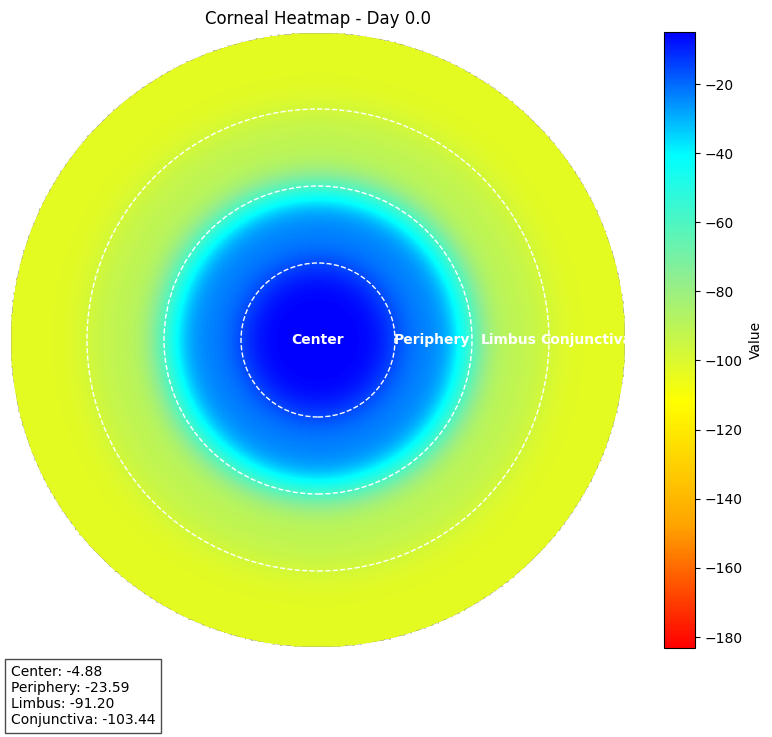

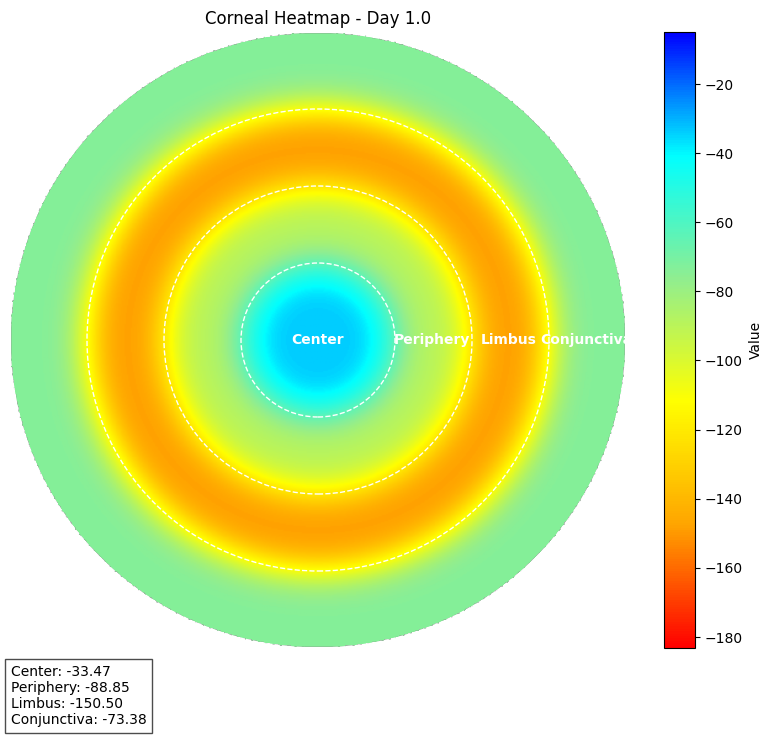

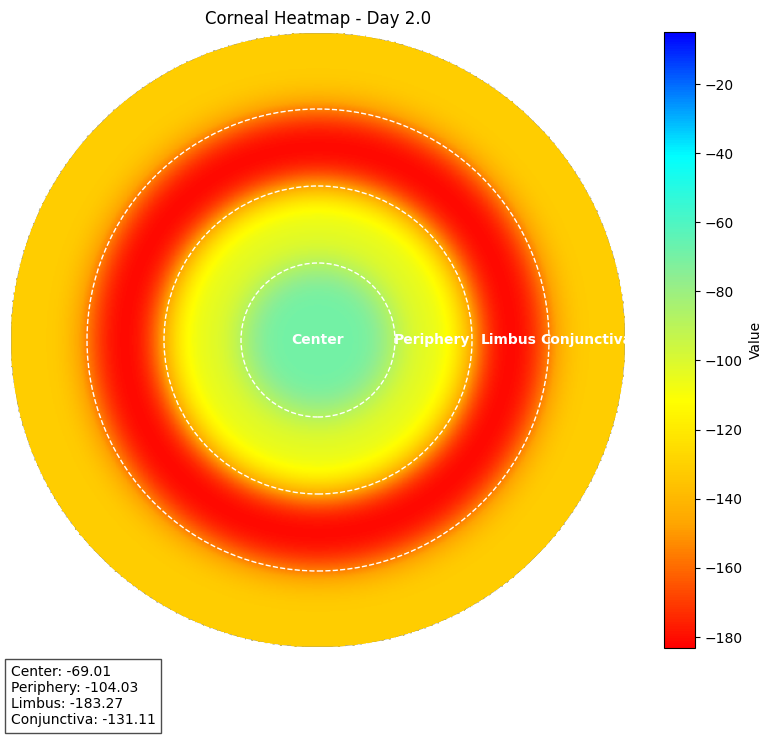

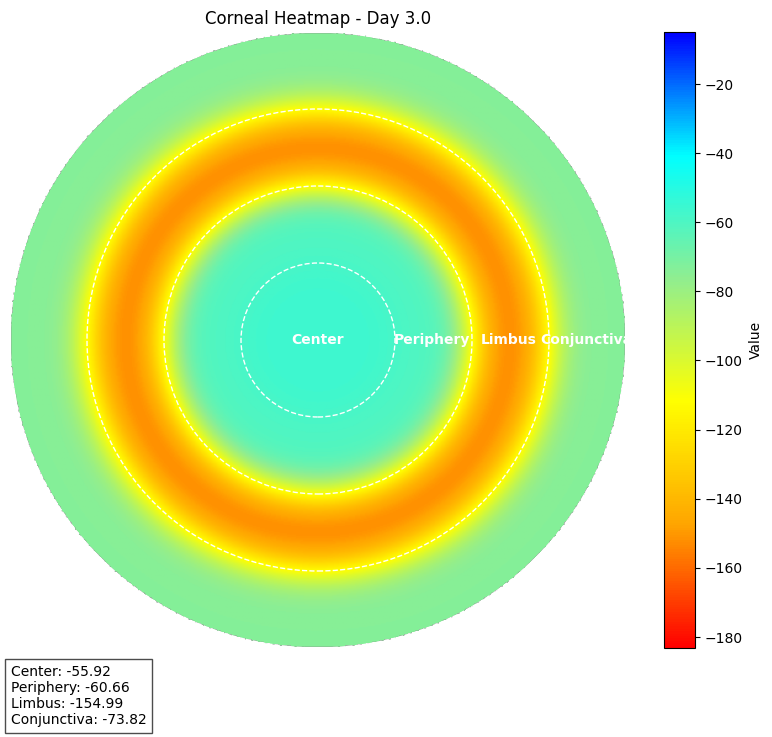

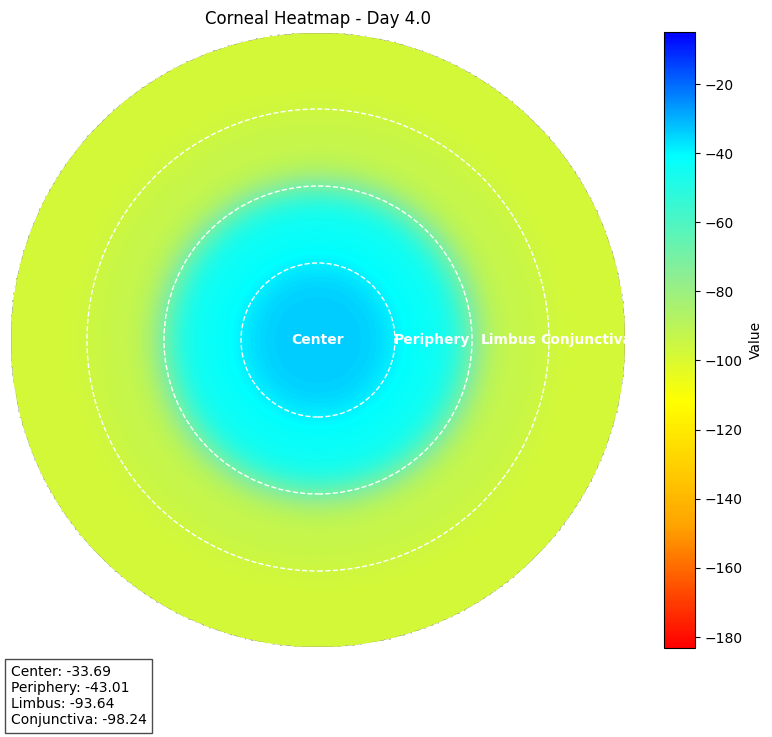

/var/folders/fg/1h3hw96d00s906nz0v0p89jm0000gn/T/ipykernel_65524/421250447.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


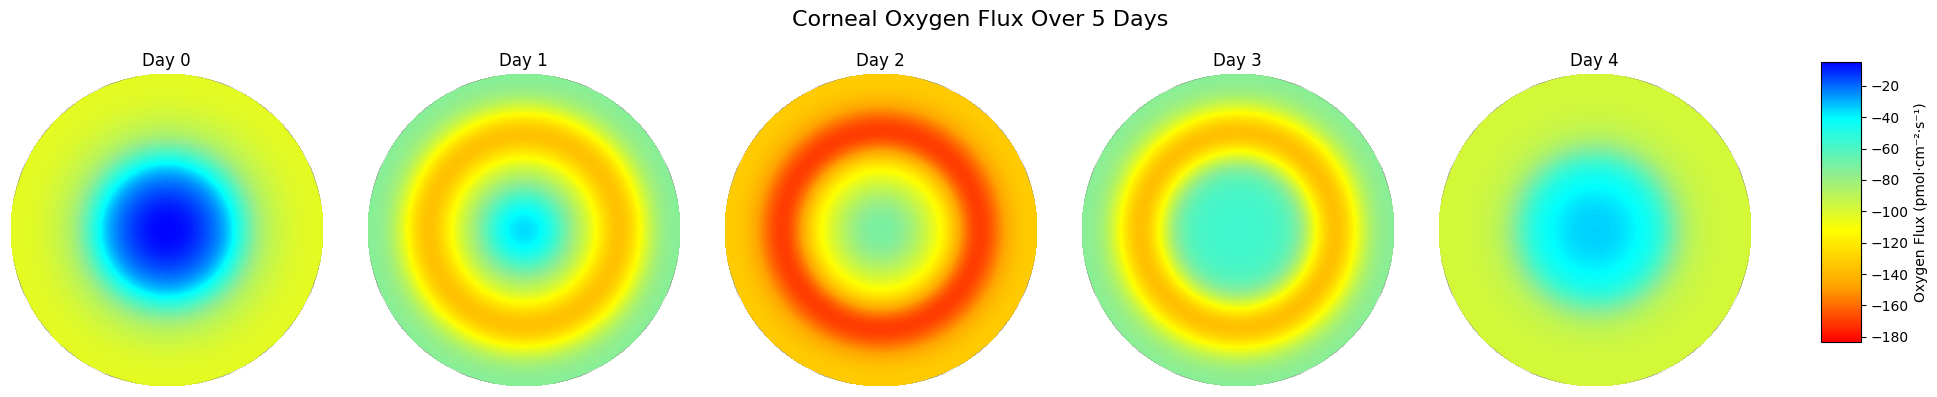

In [26]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
import pandas as pd
import matplotlib.colors as mcolors


# Function to create circular heatmap
def create_corneal_heatmap(day_data, day_num, size=500, sigma=15):
    # Create a grid for the circular heatmap
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    xx, yy = np.meshgrid(x, y)
    
    # Calculate radius at each point
    radius = np.sqrt(xx**2 + yy**2)
    
    # Initialize array with NaN values
    values = np.ones_like(radius) * np.nan
    
    # Assign values to regions based on radius
    # Center: 0.0 - 0.25 radius
    values[(radius <= 0.25)] = day_data['Center_avg']
    
    # Periphery: 0.25 - 0.50 radius
    values[(radius > 0.25) & (radius <= 0.50)] = day_data['Periphery_avg']
    
    # Limbus: 0.50 - 0.75 radius
    values[(radius > 0.50) & (radius <= 0.75)] = day_data['Limbus_avg']
    
    # Conjunctiva: 0.75 - 1.00 radius
    values[(radius > 0.75) & (radius <= 1.0)] = day_data['Conjunctiva_avg']
    
    # Create a mask for points outside the circle
    mask = radius > 1.0
    values[mask] = np.nan
    
    # Apply Gaussian blur for smooth transitions if requested
    if sigma > 0:
        # Create a temporary array for blurring (replace NaNs with zeros temporarily)
        temp_values = np.copy(values)
        mask_nan = np.isnan(temp_values)
        temp_values[mask_nan] = 0
        
        # Apply Gaussian blur
        blurred = gaussian_filter(temp_values, sigma=sigma)
        
        # Create a weight array for normalization
        weights = np.ones_like(temp_values)
        weights[mask_nan] = 0
        weight_blur = gaussian_filter(weights, sigma=sigma)
        
        # Normalize the blurred values
        blurred_normalized = blurred / (weight_blur + 1e-10)
        
        # Apply the original mask
        blurred_normalized[radius > 1.0] = np.nan
        values = blurred_normalized
    
    # Create a custom colormap: red -> orange -> yellow -> light green -> cyan -> blue -> dark blue
    colors = ['red', 'orange', 'yellow', 'lightgreen', 'cyan', 'blue']
    cmap = LinearSegmentedColormap.from_list('custom_corneal', colors)
    
    # Find global min and max for consistent color scaling across all days
    min_val = min(df['Center_avg'].min(), df['Periphery_avg'].min(), df['Limbus_avg'].min(), df['Conjunctiva_avg'].min())
    max_val = max(df['Center_avg'].max(), df['Periphery_avg'].max(), df['Limbus_avg'].max(), df['Conjunctiva_avg'].max())
    
    # Create the figure and plot
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(values, cmap=cmap, origin='lower', extent=[-1, 1, -1, 1], vmin=min_val, vmax=max_val)
    
    # Add a colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Value')
    
    # Add region labels
    ax.text(0, 0, 'Center', ha='center', va='center', color='white', fontweight='bold')
    ax.text(0.37, 0, 'Periphery', ha='center', va='center', color='white', fontweight='bold')
    ax.text(0.62, 0, 'Limbus', ha='center', va='center', color='white', fontweight='bold')
    ax.text(0.87, 0, 'Conjunctiva', ha='center', va='center', color='white', fontweight='bold')
    
    # Add circular region boundaries
    circle1 = plt.Circle((0, 0), 0.25, fill=False, color='white', linestyle='--', linewidth=1)
    circle2 = plt.Circle((0, 0), 0.50, fill=False, color='white', linestyle='--', linewidth=1)
    circle3 = plt.Circle((0, 0), 0.75, fill=False, color='white', linestyle='--', linewidth=1)
    circle4 = plt.Circle((0, 0), 1.00, fill=False, color='white', linestyle='--', linewidth=1)
    
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    ax.add_patch(circle3)
    ax.add_patch(circle4)
    
    # Set title and remove axes
    ax.set_title(f'Corneal Heatmap - Day {day_num}')
    ax.set_axis_off()
    
    # Display values for each region
    value_text = f"Center: {day_data['Center_avg']:.2f}\n"
    value_text += f"Periphery: {day_data['Periphery_avg']:.2f}\n"
    value_text += f"Limbus: {day_data['Limbus_avg']:.2f}\n"
    value_text += f"Conjunctiva: {day_data['Conjunctiva_avg']:.2f}"
    
    plt.figtext(0.02, 0.02, value_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
    
    return fig

# Create heatmaps for each day
for i, day in df.iterrows():
    day_num = day['Day']
    fig = create_corneal_heatmap(day, day_num)
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(f'corneal_heatmap_day_{int(day_num)}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Create a single figure with all days for comparison
fig, axes = plt.subplots(1, len(df), figsize=(4*len(df), 4))
min_val = min(df['Center_avg'].min(), df['Periphery_avg'].min(), df['Limbus_avg'].min(), df['Conjunctiva_avg'].min())
max_val = max(df['Center_avg'].max(), df['Periphery_avg'].max(), df['Limbus_avg'].max(), df['Conjunctiva_avg'].max())

# Custom colormap
colors = ['red', 'orange', 'yellow', 'lightgreen', 'cyan', 'blue']
cmap = LinearSegmentedColormap.from_list('custom_corneal', colors)

for i, day in df.iterrows():
    day_num = day['Day']
    ax = axes[i]
    
    # Create a grid
    size = 300
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    xx, yy = np.meshgrid(x, y)
    radius = np.sqrt(xx**2 + yy**2)
    
    # Initialize array with NaN values
    values = np.ones_like(radius) * np.nan
    
    # Assign values to regions
    values[(radius <= 0.25)] = day['Center_avg']
    values[(radius > 0.25) & (radius <= 0.50)] = day['Periphery_avg']
    values[(radius > 0.50) & (radius <= 0.75)] = day['Limbus_avg']
    values[(radius > 0.75) & (radius <= 1.0)] = day['Conjunctiva_avg']
    
    # Apply blur
    temp_values = np.copy(values)
    mask_nan = np.isnan(temp_values)
    temp_values[mask_nan] = 0
    blurred = gaussian_filter(temp_values, sigma=15)
    weights = np.ones_like(temp_values)
    weights[mask_nan] = 0
    weight_blur = gaussian_filter(weights, sigma=15)
    blurred_normalized = blurred / (weight_blur + 1e-10)
    blurred_normalized[radius > 1.0] = np.nan
    
    # Plot
    im = ax.imshow(blurred_normalized, cmap=cmap, origin='lower', extent=[-1, 1, -1, 1], vmin=min_val, vmax=max_val)
    
    ax.set_title(f'Day {int(day_num)}')
    ax.set_axis_off()

# Add a colorbar for all plots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Oxygen Flux (pmol·cm⁻²·s⁻¹)')

plt.suptitle('Corneal Oxygen Flux Over 5 Days', fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.savefig('corneal_heatmap_all_days.png', dpi=300, bbox_inches='tight')
plt.show()